# Hubbard correction (DFT+U)
In this example, we'll plot the DOS and projected DOS of Nickel Oxide
with and without the Hubbard term correction.

In [1]:
using DFTK
using PseudoPotentialData
using Unitful
using UnitfulAtomic
using Plots

Define the geometry and pseudopotential

In [2]:
a = 7.9  # Nickel Oxide lattice constant in Bohr
lattice = a * [[ 1.0  0.5  0.5];
               [ 0.5  1.0  0.5];
               [ 0.5  0.5  1.0]]
pseudopotentials = PseudoFamily("dojo.nc.sr.pbe.v0_4_1.standard.upf")
Ni = ElementPsp(:Ni, pseudopotentials)
O  = ElementPsp(:O, pseudopotentials)
atoms = [Ni, O, Ni, O]
positions = [zeros(3), ones(3) / 4, ones(3) / 2, ones(3) * 3 / 4]
magnetic_moments = [2, 0, -1, 0]

4-element Vector{Int64}:
  2
  0
 -1
  0

First, we run an SCF and band computation without the Hubbard term

In [3]:
model = model_DFT(lattice, atoms, positions; temperature=5e-3,
                  functionals=PBE(), magnetic_moments)
basis = PlaneWaveBasis(model; Ecut=20, kgrid=[2, 2, 2])
scfres = self_consistent_field(basis; tol=1e-6, ρ=guess_density(basis, magnetic_moments))
bands = compute_bands(scfres, MonkhorstPack(4, 4, 4))
lowest_unocc_band = findfirst(ε -> ε-bands.εF > 0, bands.eigenvalues[1])
band_gap = bands.eigenvalues[1][lowest_unocc_band] - bands.eigenvalues[1][lowest_unocc_band-1]

┌ Warning: Negative ρcore detected: -0.0006182370306135084
└ @ DFTK ~/work/DFTK.jl/DFTK.jl/src/terms/xc.jl:39
n     Energy            log10(ΔE)   log10(Δρ)   Magnet   |Magn|   Diag   Δtime 
---   ---------------   ---------   ---------   ------   ------   ----   ------
  1   -361.8611926775                    0.07    1.335    3.439    6.9    4.16s
  2   -363.2977524689        0.16       -0.22   -0.165    3.003    3.2    3.03s
  3   -363.5366705445       -0.62       -0.60   -0.039    2.897    3.6    2.66s
  4   -363.5546737249       -1.74       -1.14   -0.007    2.866    2.8    2.91s
  5   -363.5546924025       -4.73       -1.78    0.007    2.852    1.2    1.80s
  6   -363.5548783290       -3.73       -2.23    0.006    2.857    1.0    1.65s
  7   -363.5550019335       -3.91       -2.47    0.002    2.863    1.4    1.76s
  8   -363.5550300646       -4.55       -2.85    0.001    2.867    1.2    1.71s
  9   -363.5550351555       -5.29       -3.31    0.000    2.869    1.8    1.80s
 10   -363

0.08219341142145775

Then we plot the DOS and the PDOS for the relevant 3D (pseudo)atomic projector

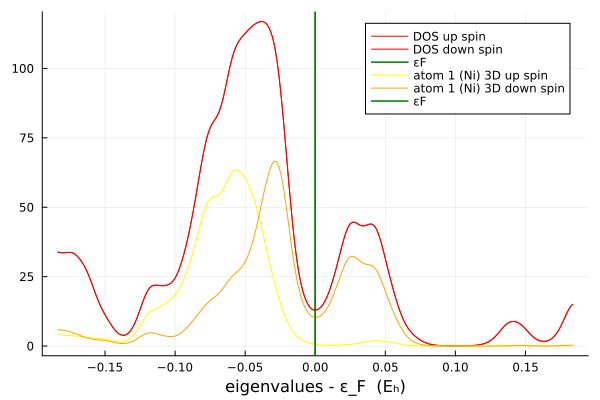

In [4]:
εF = bands.εF
width = 5.0u"eV"
εrange = (εF - austrip(width), εF + austrip(width))
p = plot_dos(bands; εrange, colors=[:red, :red])
plot_pdos(bands; p, iatom=1, label="3D", colors=[:yellow, :orange], εrange)

To perform and Hubbard computation, we have to define the Hubbard manifold and associated constant.

In DFTK there are a few ways to construct the `OrbitalManifold`.
Here, we will apply the Hubbard correction on the 3D orbital of all nickel atoms.
To select all nickel atoms, we can:
- Pass the `Ni` element directly.
- Pass the `:Ni` symbol.
- Pass the list of atom indices, here `[1, 3]`.

To select the orbitals, it is recommended to use their label, such as `"3D"`
for PseudoDojo pseudopotentials.

Note that "manifold" is the standard term used in the literature for the set of atomic orbitals
used to compute the Hubbard correction, but it is not meant in the mathematical sense.

In [5]:
U = 10u"eV"
# Alternative:
# manifold = OrbitalManifold(:Ni, "3D")
# Alternative:
# manifold = OrbitalManifold([1, 3], "3D")
manifold = OrbitalManifold(Ni, "3D")

OrbitalManifold(Ni, "3D")

Run SCF with a DFT+U setup, notice the `extra_terms` keyword argument, setting up the Hubbard +U term.
It is also possible to set up multiple manifolds with different U values by passing each pair
as a separate entry in the `Hubbard` constructor (i.e. `Hubbard(manifold1 => U1, manifold2 => U2, etc.)`)
or as two vectors (i.e. `Hubbard([manifold1, manifold2, etc.], [U1, U2, etc.])`).

In [6]:
model = model_DFT(lattice, atoms, positions; extra_terms=[Hubbard(manifold => U)],
                  functionals=PBE(), temperature=5e-3, magnetic_moments)
basis = PlaneWaveBasis(model; Ecut=20, kgrid=[2, 2, 2])
scfres = self_consistent_field(basis; tol=1e-6, ρ=guess_density(basis, magnetic_moments));

┌ Warning: Negative ρcore detected: -0.0006182370306135084
└ @ DFTK ~/work/DFTK.jl/DFTK.jl/src/terms/xc.jl:39
n     Energy            log10(ΔE)   log10(Δρ)   Magnet   |Magn|   Diag   Δtime 
---   ---------------   ---------   ---------   ------   ------   ----   ------
  1   -361.3869275648                    0.07    1.336    3.439    6.8    4.22s
  2   -363.2384290498        0.27       -0.21    0.014    3.623    3.1    8.79s
  3   -363.3507938401       -0.95       -0.58    0.000    3.727    3.4    3.61s
  4   -363.3889922046       -1.42       -1.18    0.000    3.717    2.6    2.46s
  5   -363.3959528313       -2.16       -1.66    0.000    3.681    2.0    2.25s
  6   -363.3973156706       -2.87       -2.04    0.000    3.656    1.5    1.95s
  7   -363.3976053307       -3.54       -2.27    0.000    3.647    2.4    2.22s
  8   -363.3976895256       -4.07       -2.62    0.000    3.647    1.4    2.57s
  9   -363.3977062191       -4.78       -2.95    0.000    3.649    2.1    2.19s
 10   -363

Run band computation

In [7]:
bands_hub = compute_bands(scfres, MonkhorstPack(4, 4, 4))
lowest_unocc_band = findfirst(ε -> ε-bands_hub.εF > 0, bands_hub.eigenvalues[1])
band_gap = bands_hub.eigenvalues[1][lowest_unocc_band] - bands_hub.eigenvalues[1][lowest_unocc_band-1]

┌ Warning: Negative ρcore detected: -0.0006182370306135084
└ @ DFTK ~/work/DFTK.jl/DFTK.jl/src/terms/xc.jl:39


0.11667607623485848

With the electron localization introduced by the Hubbard term, the band gap has now opened,
reflecting the experimental insulating behaviour of Nickel Oxide.

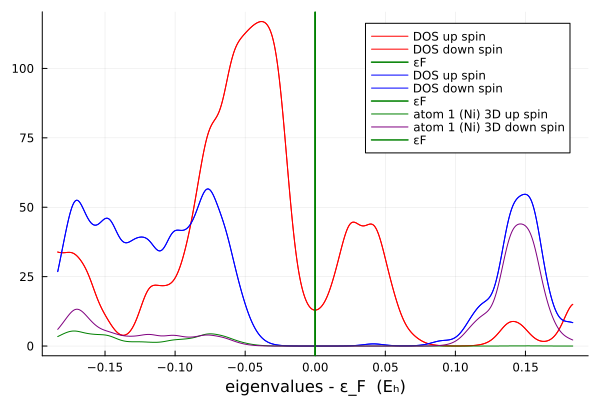

In [8]:
εF = bands_hub.εF
εrange = (εF - austrip(width), εF + austrip(width))
p = plot_dos(bands_hub; p, colors=[:blue, :blue], εrange)
plot_pdos(bands_hub; p, iatom=1, label="3D", colors=[:green, :purple], εrange)